In [31]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy.signal import butter,filtfilt,welch
from scipy import signal
from mne.time_frequency import psd_array_multitaper
import optuna
import numpy as np  
import optuna.visualization as vis
from optuna.pruners import MedianPruner
import plotly
from scipy.stats import chisquare

In [32]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')

In [33]:
fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params,Normalizacion):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params

    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f"./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[50:, 1]  
     
    if(Normalizacion=="max_global"):    
        data=data / max(data)
    elif(Normalizacion=="max_global_abs"):
        data=data / max(abs(data))
    elif(Normalizacion=="zscore"):
        data=(data - np.mean(data)) / np.std(data)

    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full',n_jobs=2)
    frequencies=np.array(frequencies)

    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



In [34]:
def Datos_reales(nombres,Normalizacion):
    Datos = np.empty(len(nombres), dtype=object)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    mean_welch=np.zeros(481)
    mean_Delta = np.zeros(2)
    mean_Theta = np.zeros(2)
    mean_Alpha = np.zeros(2)
    mean_Beta = np.zeros(2)

    all_signals=np.empty_like(Datos)
    for i, nombre in enumerate(nombres): 
        all_signals[i]=np.loadtxt(nombre)

    all_values = np.concatenate(all_signals)  # Combinar todos los datos
    global_max = np.max(all_values)
    global_max_abs = np.max(abs(all_values))
    global_mean = np.mean(all_values)
    global_std = np.std(all_values)

    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre 
        data = np.loadtxt(nombre)

        if(Normalizacion=="max_global"):    
            data=data / global_max
        elif(Normalizacion=="max_global_abs"):
            data=data /global_max_abs
        elif(Normalizacion=="zscore"):
            data=(data -global_mean) / global_std

        Datos[i]=data
        Butter[i]=butter= signal.filtfilt(b, a,data)

        psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full')
        Frequencies[i]=frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        mean_welch+=welch_data/len(nombres)

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        mean_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        mean_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        mean_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        mean_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,"mean_welch":mean_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'mean_Delta': mean_Delta,'mean_Theta':mean_Theta,"mean_Alpha":mean_Alpha,"mean_Beta":mean_Beta
    }


In [35]:
Params={'L': 21, 'P': 0.7747165319165528, 'Inh': 0.9998660702705271, 'Trest': 0.5400888844984987, 'Trelative': 0.9350696961194813, 'C_h': 0.7257340056126693, 'Tipo_red': 1}
initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8030, Params["Tipo_red"]]

Normalizacion="max_global"###"max_global""max_global_abs" zscore
generated_data = Simulado_EGG(initial_params,Normalizacion)


reales_total = Datos_reales(["Datos_reales/P3_MNE.txt","Datos_reales/Pz_MNE.txt","Datos_reales/P4_MNE.txt"],Normalizacion)

    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


['Datos_reales/P3_MNE.txt' 'Datos_reales/Pz_MNE.txt'
 'Datos_reales/P4_MNE.txt']


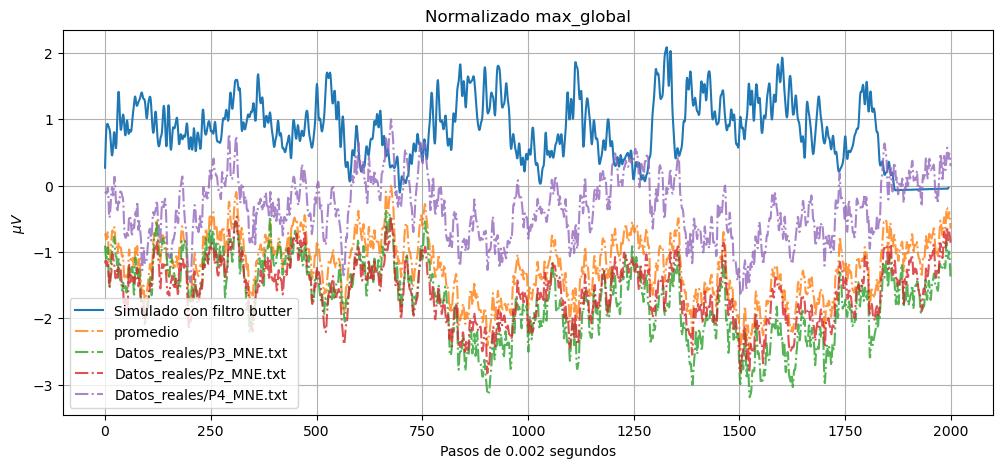

In [36]:
fig, ax = plt.subplots(figsize=[12, 5])

print(reales_total["Nombres"])
#ax.plot(generated_data["data_resample"],label="Simulado")
ax.plot(generated_data["butter"][:],label="Simulado con filtro butter")
grupos = np.array([reales_total["datos"][0], reales_total["datos"][1], reales_total["datos"][2]])
promedio = np.mean(grupos, axis=0) 
ax.plot(promedio,"-.", label="promedio",alpha=0.8)
for i in range(3):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.8)


plt.xlabel("Pasos de 0.002 segundos")
plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.title(f"Normalizado {Normalizacion}")
plt.show()  # Mostrar todos los gráficos en la misma figura


[0.         0.25062657 0.50125313 0.7518797  1.00250627 1.25313283
 1.5037594  1.75438596 2.00501253 2.2556391  2.50626566 2.75689223
 3.0075188  3.25814536 3.50877193 3.7593985  4.01002506 4.26065163
 4.5112782  4.76190476 5.01253133 5.26315789 5.51378446 5.76441103
 6.01503759 6.26566416 6.51629073 6.76691729 7.01754386 7.26817043
 7.51879699 7.76942356]
479
481
241
['Datos_reales/P3_MNE.txt' 'Datos_reales/Pz_MNE.txt'
 'Datos_reales/P4_MNE.txt']
Delta [-14.116042853006457, 0.7464620297519158] ---- [-16.27673048   2.88731357]
Theta [-19.8539911701021, 1.5802650047406903] ---- [-20.92068321   1.24868298]
Alpha [-26.52299073259342, 2.0419200514899343] ---- [-23.45965005   1.65514777]
Beta [-30.319270466078727, 2.355647938730464] ---- [-30.85932355   2.14585146]


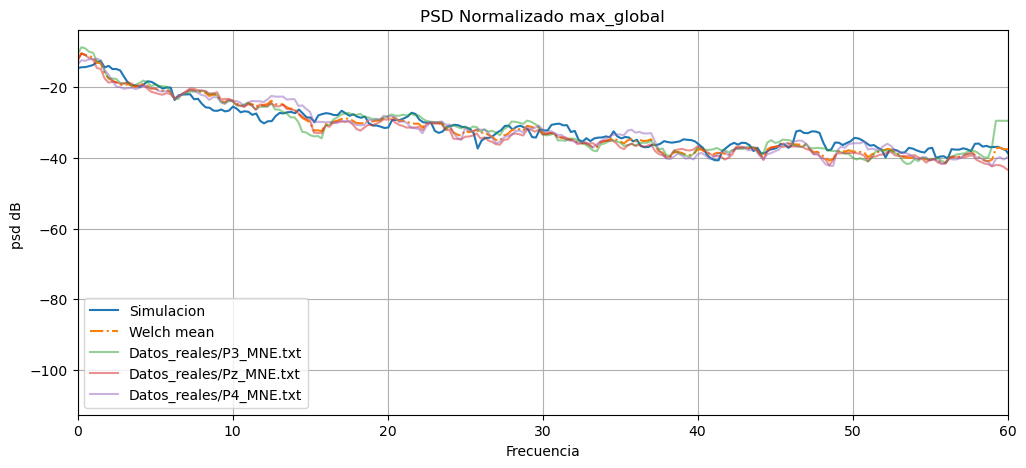

In [37]:
fig, ax = plt.subplots(figsize=[12, 5])
#print(generated_data["frequencies"])
print(generated_data["frequencies"][:32])
print(len(generated_data["frequencies"]))
print(len(reales_total["frequencies"][0]))
frequencies = reales_total["frequencies"][0]
count_in_range = np.sum((frequencies >= 0) & (frequencies <= 60))
print(count_in_range)

print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["mean_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["mean_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["mean_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["mean_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
ax.plot(reales_total["frequencies"][0],reales_total["mean_welch"],label="Welch mean",linestyle="-.")
for i in range(3):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i],alpha=0.5)

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.grid()
plt.xlim(0,60)
plt.title(f"PSD Normalizado {Normalizacion}")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [ ]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',50,100)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest', -10.0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
         ### ------------------ Por bandas
        # dif_Delta=generated_data_total["delta"]-reales_total["main_Delta"]
        # dif_Theta=generated_data_total["theta"]-reales_total["main_Theta"]
        # dif_Alpha=generated_data_total["alpha"]-reales_total["main_Alpha"]
        # dif_Beta=generated_data_total["beta"]-reales_total["main_Beta"]
        # difference = (np.sum(np.abs(dif_Delta)) +
        #                     np.sum(np.abs(dif_Theta)) +
        #                     np.sum(np.abs(dif_Alpha)) +
        #                     np.sum(np.abs(dif_Beta)))
        
        ### -------------------- Chi
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:241], f_exp=reales_total["mean_welch"][:241])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi60_{Normalizacion}2", 
                            storage=f"sqlite:///Estudios/Full/Chi60_{Normalizacion}2.db", 
                            load_if_exists=True,pruner=MedianPruner())

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=1000)


[I 2024-10-31 21:12:37,108] Using an existing study with name 'Chi60_max_global2' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[I 2024-10-31 21:12:42,191] Trial 996 finished with value: 1183.2476748352283 and parameters: {'L': 52, 'P': 0.9181497213822322, 'Inh': 0.038665290348355044, 'Trest': -9.99049502345729, 'Trelative': -1.3335849263511372, 'C_h': 0.7208881322037904, 'Tipo_red': 1}. Best is trial 829 with value: 54.42228179817481.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[I 2024-10-31 21:13:00,696] Trial 997 finished with value: 7666.2303468656755 and parameters: {'L': 67, 'P': 0.9311863245844331, 'Inh': 0.021667216015658616, 'Trest': -8.934833725793794, 'Trelative': -0.9940840290696021, 'C_h': 0.6973589235244787, 'Tipo_red': 1}. Best is trial 829 with value: 54.42228179817481.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[I 2024-10-31 21:13:03,767] Trial 998 finished with value: 43069.52483080495 and parameters: {'L': 51, 'P': 0.9631115135789743, 'Inh': 0.04489909662799888, 'Trest': -9.363123329009307, 'Trelative': -3.688263586232142, 'C_h': 0.6763750948902669, 'Tipo_red': 1}. Best is trial 829 with value: 54.42228179817481.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[I 2024-10-31 21:13:07,780] Trial 999 finished with value: 41139.9082297968 and parameters: {'L': 54, 'P': 0.9824972940300152, 'Inh': 0.01795287590228313, 'Trest': -8.341361936646397, 'Trelative': -1.7913076230719747, 'C_h': 0.6612028089103525, 'Tipo_red': 1}. Best is trial 829 with value: 54.42228179817481.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[I 2024-10-31 21:13:33,151] Trial 1000 finished with value: 8670.183220878025 and parameters: {'L': 72, 'P': 0.9464456049818044, 'Inh': 0.039235611206775683, 'Trest': -9.254480525988983, 'Trelative': -0.7505465715866595, 'C_h': 0.6929882763320525, 'Tipo_red': 1}. Best is trial 829 with value: 54.42228179817481.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-10-31 21:14:00,462] Trial 1001 finished with value: 38001.52354343795 and parameters: {'L': 90, 'P': 0.907503231151411, 'Inh': 0.6088917904787349, 'Trest': -8.625304564216087, 'Trelative': -1.6041292057760823, 'C_h': 0.6457052096551378, 'Tipo_red': 1}. Best is trial 829 with value: 54.42228179817481.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[I 2024-10-31 21:14:05,456] Trial 1002 finished with value: 2027.5473186410625 and parameters: {'L': 50, 'P': 0.9322945014545047, 'Inh': 0.017476861696675637, 'Trest': -9.585833056124132, 'Trelative': -1.1886939826688412, 'C_h': 0.6733141403995716, 'Tipo_red': 1}. Best is trial 829 with value: 54.42228179817481.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[I 2024-10-31 21:14:17,153] Trial 1003 finished with value: 3714.4805334218045 and parameters: {'L': 65, 'P': 0.9137272918923369, 'Inh': 0.05438910829579639, 'Trest': -8.92375800326802, 'Trelative': -1.464972919079481, 'C_h': 0.7115501680536092, 'Tipo_red': 1}. Best is trial 829 with value: 54.42228179817481.


In [19]:

print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:10]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


Chi60_max_global_abs

Trial 1:
Params: {'L': 20, 'P': 0.30263204249074005, 'Inh': 0.19763823476347875, 'Trest': 0.24204394961378473, 'Trelative': 2.8173424531872198, 'C_h': 0.9608085181196933, 'Tipo_red': 1}
Value: 638.2277073870314

Trial 2:
Params: {'L': 21, 'P': 0.3167814878163586, 'Inh': 0.2146201484742383, 'Trest': 0.19726354282529646, 'Trelative': 2.537643571170378, 'C_h': 0.9993124287683728, 'Tipo_red': 1}
Value: 700.1066721059981

Trial 3:
Params: {'L': 21, 'P': 0.3499711870644519, 'Inh': 0.19069257892346686, 'Trest': 0.2349437034325374, 'Trelative': 3.2179861647477273, 'C_h': 0.985323334028644, 'Tipo_red': 1}
Value: 722.0990013570118

Trial 4:
Params: {'L': 21, 'P': 0.39860536317233664, 'Inh': 0.26216848301296153, 'Trest': 0.9488445349474315, 'Trelative': 3.052839130770724, 'C_h': 0.9996768768654798, 'Tipo_red': 1}
Value: 759.984179117816

Trial 5:
Params: {'L': 20, 'P': 0.3534593463063011, 'Inh': 0.24006843398427857, 'Trest': 0.5807962186764756, 'Trelative': 3.166461055205125

In [11]:
vis.plot_param_importances(study)

In [12]:
vis.plot_parallel_coordinate(study)

In [13]:
optuna.visualization.plot_slice(study)